# Using Group Id's the Right Way!


**TL:DR** :: Creating a model that reduces the inter-group dependency and validation error by using pair-wise comparisons. 

Hi All,
Although a little late to the party; I wanted to try out the competition but wasn't able to accept the competition rules in time. I decided to give it a try anyway. Read the discussions and found out about the data linkage hack and decided to find a way to use Group Id's in a way that the final model would only depend on the 128 time series values from the given training data.

### Model Layout:

So the basic idea for the project is to create a model that can reduces the modelling of group-specific patterns from the data and generalize well by focusing on surface-specific patternes in the data. The focus is on reducing inter-group validation error.
To do so, I have created a model that has the following structure:

**Input**:
Total inputs = 4 (2 for each samples)
*  Time series data for 2 samples, size = 128 (times steps) x 12 (features) each
*  Meta data for 2 samples, size = 8 x 12 (features) each

**Output**:
Total outputs = 4
*  2 Surface prediction, one for each sample.
*  Prediction wheter both samples have same Group Id.
*  Prediction wheter samples are take from same surface.

### Model Structure:
**first_inner model**:
This consists of raw time series input being fed into multiple CNN layers followed by a Bi-LSTM. Then it takes the global avg/max pooling for last CNN and Bi-LSTM and connects it to a FC layer.
Meta_Data is then concatenated to this FC layer which is again followed by a FC layer.

**second_inner model**:
This only consists of FC layers and the final output layer.

**main_model**:
This consists of 2 pairs of first_inner and second_inner models, followed by a few lambda layers that basically compare the output of the both the first_inner models. And predicts if the both the samples are from same group and if both the samples are of the same surface.

### Model for making predictions:
**Predictions**:
For final predictions, I didn't feel the need to create a separate model so I just feedfoward the data through first_inner and second_inner model sequentially.


## Feature Engineering:
Since the main intent was to just reduce the inter_group dependencies, I only scratched the surface of the data during FE. Computed basic statistical values from features for the Meta_data. 
Since the orientation data didnt

In [1]:
# Basics Imports for the kernel

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score
from scipy.stats import skew,kurtosis
from sklearn.preprocessing import StandardScaler
from numpy.fft import *
import keras
import math

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['X_train.csv', 'sample_submission.csv', 'X_test.csv', 'y_train.csv']


Reading the Data in:

In [2]:
train_df = pd.read_csv('../input/X_train.csv')
test_df = pd.read_csv('../input/X_test.csv')

Checking out what the data represents:

In [3]:
train_df.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [4]:
test_df.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


Converting Quaternion to Euler and Tait Angles

In [5]:
# https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
def quaternion_to_euler(x, y, z, w):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [6]:
def quaternions_conversion_1(actual):
    """Quaternions to Euler Angles"""
    
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    return actual

In [7]:
def quaternion_to_tait(q_val):
    #We assume q_val is in this format: [qw, q1, q2, q3]
    #And the quaternion is normalized
    roll = np.arctan2(2*(q_val[0]*q_val[1] + q_val[2]*q_val[3]),1 - 2*(q_val[1]*q_val[1] + q_val[2]*q_val[2]))
    pitch = np.arcsin(2*(q_val[0]*q_val[2] - q_val[3]*q_val[1]))
    yaw = np.arctan2(2*(q_val[0]*q_val[3] + q_val[1]*q_val[2]),1 - 2*(q_val[2]*q_val[2] + q_val[3]*q_val[3]))
    return roll, pitch, yaw

In [8]:
def quaternions_conversion_2(actual):
    """Quaternions to Tait Angles"""
    
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nr, np, ny = [], [], []
    for i in range(len(x)):
        rr, pp, yy = quaternion_to_tait([w[i], x[i], y[i], z[i]])
        nr.append(rr)
        np.append(pp)
        ny.append(yy)
    
    actual['roll'] = nr
    actual['pitch'] = np
    actual['yaw'] = ny
    
    return actual

Fucntion to de-noise the data using FFT

In [9]:
# from @theoviel at https://www.kaggle.com/theoviel/fast-fourier-transform-denoising
def filter_signal(signal, threshold=1e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [10]:
def calculate_diffs(data,feature_columns):
        for ii,col in enumerate(feature_columns):
            if col in ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W','euler_x', 'euler_y', 'euler_z','roll','pitch','yaw']:
                np_arr = data[:,:,ii]
                roll_arr = np.copy(np_arr)
                roll_arr[:,1:] = roll_arr[:,:-1]
                np_arr = np_arr - roll_arr
                data[:,:,ii] = np_arr
                print(f'Calculated Diffs  : {col}')
            else:
                pass
                #print(f'Not changed : {col}')
        return data

In [11]:
def denoise(df,feature_columns):
    for ii,col in enumerate(feature_columns):
        if col in ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X','linear_acceleration_Y', 'linear_acceleration_Z']:
            denoised=df.groupby('series_id')[col].apply(lambda x:filter_signal(x))
            list_denoised = []
            for arr in denoised:
                for val in arr:
                    list_denoised.append(val)
            df[col] = list_denoised
            print(f'Denoised          : {col}')
        else:
            pass
            #print(f'Not changed : {col}')
    return df

Function to process the Training and Test data:

In [12]:
def process_data(train_df, Scalers=[]):
    
    feature_columns = train_df.columns[3:]
    train_df = denoise(train_df,feature_columns)
    train_df['totl_anglr_vel'] = np.power(np.power(train_df['angular_velocity_X'].values,2) + np.power(train_df['angular_velocity_Y'].values,2) \
                                      + np.power(train_df['angular_velocity_Z'].values,2),0.5)   

    train_df['totl_linear_accel'] = np.power(np.power(train_df['linear_acceleration_X'].values,2) + np.power(train_df['linear_acceleration_Y'].values,2) \
                                          + np.power(train_df['linear_acceleration_Z'].values,2),0.5) 
        
    train_df = quaternions_conversion_1(train_df)
    train_df = quaternions_conversion_2(train_df)
    
    feature_columns = train_df.columns[7:]
    features    = len(feature_columns)
    data = train_df[feature_columns].values
    data = data.reshape((data.shape[0]//128,128,features))
    
    data = calculate_diffs(data,feature_columns)
    
    
    meta_data = pd.DataFrame()
    for ii,col in enumerate(feature_columns):
        meta_data[col+'_mean'] = data[:,:,ii].mean(axis=1)
        meta_data[col+'_std']  = data[:,:,ii].std(axis=1)
        
        meta_data[col+'_min']  = data[:,:,ii].min(axis=1)
        meta_data[col+'_max']  = data[:,:,ii].max(axis=1)

        meta_data[col+'_diff_mean']  = np.diff(data[:,:,ii],axis=1).mean(axis=1)
        meta_data[col+'_diff_std']   = np.diff(data[:,:,ii],axis=1).std(axis=1)
        
        meta_data[col+'_skew']     = skew(data[:,:,ii],axis=1)
        meta_data[col+'_kurtosis'] = kurtosis(data[:,:,ii],axis=1)
        
    data = data.reshape((data.shape[0]*128,features))
    if Scalers==[]:
        SS = StandardScaler()
        SS.fit(data)
        Scalers.append(SS)
        SS_Meta = StandardScaler() 
        SS_Meta.fit(meta_data)
        Scalers.append(SS_Meta)
        
    data      = Scalers[0].transform(data)
    meta_data = Scalers[1].transform(meta_data)
         
    data = data.reshape((data.shape[0]//128,128,features))
    
    return data,meta_data,Scalers

In [13]:
data_train,meta_data_train,Scalers=process_data(train_df)

Denoised          : angular_velocity_X
Denoised          : angular_velocity_Y
Denoised          : angular_velocity_Z
Denoised          : linear_acceleration_X
Denoised          : linear_acceleration_Y
Denoised          : linear_acceleration_Z
Calculated Diffs  : euler_x
Calculated Diffs  : euler_y
Calculated Diffs  : euler_z
Calculated Diffs  : roll
Calculated Diffs  : pitch
Calculated Diffs  : yaw


In [14]:
data_test,meta_data_test,_=process_data(test_df,Scalers)

Denoised          : angular_velocity_X
Denoised          : angular_velocity_Y
Denoised          : angular_velocity_Z
Denoised          : linear_acceleration_X
Denoised          : linear_acceleration_Y
Denoised          : linear_acceleration_Z
Calculated Diffs  : euler_x
Calculated Diffs  : euler_y
Calculated Diffs  : euler_z
Calculated Diffs  : roll
Calculated Diffs  : pitch
Calculated Diffs  : yaw


In [15]:
train_y = pd.read_csv('../input/y_train.csv')

In [16]:
num_classes = len(train_y.surface.unique())
segments    = train_y.surface.size
features    = data_train.shape[2]

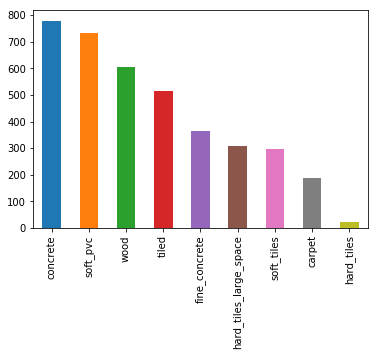

In [17]:
target = train_y.surface
_=train_y.surface.value_counts().plot(kind='bar')

From the histogram we can see that the classes are not blanced, hence we need to incorporate this imbalance in out model.

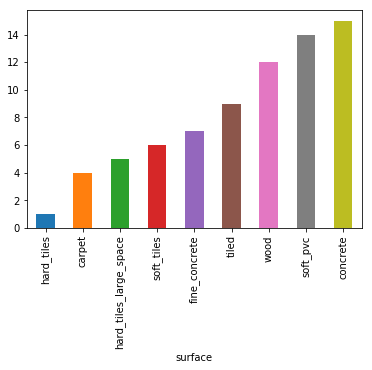

In [18]:
_=train_y.groupby('surface').group_id.unique().map(lambda x:len(x)).sort_values().plot(kind='bar')

Processing the surface labels to be understood by the model. 

Then creating training and validation sets using GroupShuffleSplit. Also ensuring that all training sets contain the hard-tiles group since there is only one group for this surface as shown from above histogram.

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target = le.fit_transform(train_y['surface'])

GS = GroupShuffleSplit(n_splits=13,random_state=513131,test_size=0.1)
folds = [(t,v) for (t,v) in GS.split(np.zeros((segments,)),groups=train_y.group_id)]

groups_hard_tiles = train_y.group_id[train_y.surface=='hard_tiles'].index.tolist()

folds_set = []
for t,v in folds:
    folds_set.append((np.array(list(set(t).union(groups_hard_tiles))),np.array(list(set(v).difference(groups_hard_tiles)))))
    
for ii,(t,v) in enumerate(folds_set):
    if 'hard_tiles' in train_y.surface.iloc[v].unique():
        print("Hard_Tiles present in fold no: {ii+1}")
else:
    print('Hard_tiles group is excluded from the validation sets')

Hard_tiles group is excluded from the validation sets


In [20]:
gc.collect()

2937

# Model Creation Starts Here

First_inner and second_inner model generator functions:

In [21]:
def first_inner_generator(out_units,l2,Spatial_dropout,dense_drop,noise):
    
    
    input_main = keras.layers.Input(shape=(128,features))

    cnn        = keras.layers.GaussianNoise(noise)(input_main)
    
    cnn        = keras.layers.Conv1D(out_units+(out_units//4)*0,3,kernel_regularizer=keras.regularizers.l2(l2))(cnn)
    cnn        = keras.layers.Activation('relu')(cnn)
    cnn        = keras.layers.SpatialDropout1D(Spatial_dropout)(cnn)
    cnn        = keras.layers.MaxPool1D()(cnn)
    
    cnn        = keras.layers.Conv1D(out_units+(out_units//4)*1,3,kernel_regularizer=keras.regularizers.l2(l2))(cnn)
    cnn        = keras.layers.Activation('relu')(cnn)
    cnn        = keras.layers.SpatialDropout1D(Spatial_dropout)(cnn)
    cnn        = keras.layers.MaxPool1D()(cnn)
    
    cnn        = keras.layers.Conv1D(out_units+(out_units//4)*2,3,kernel_regularizer=keras.regularizers.l2(l2))(cnn)
    cnn        = keras.layers.Activation('relu')(cnn)
    cnn        = keras.layers.SpatialDropout1D(Spatial_dropout)(cnn)
    
    cnn        = keras.layers.Conv1D(out_units+(out_units//4)*3,3,kernel_regularizer=keras.regularizers.l2(l2))(cnn)
    cnn        = keras.layers.Activation('relu')(cnn)
    cnn        = keras.layers.SpatialDropout1D(Spatial_dropout)(cnn)
    
    cnn        = keras.layers.Conv1D(out_units+(out_units//4)*4,3,kernel_regularizer=keras.regularizers.l2(l2))(cnn)
    cnn        = keras.layers.Activation('relu')(cnn)
    cnn        = keras.layers.SpatialDropout1D(Spatial_dropout)(cnn)
    
    LSTM       = keras.layers.Bidirectional(keras.layers.CuDNNLSTM(out_units,return_sequences=True,kernel_regularizer=keras.regularizers.l2(l2)))(cnn)
    
    max_cnn    = keras.layers.GlobalMaxPool1D()(cnn)
    avg_cnn    = keras.layers.GlobalAvgPool1D()(cnn)
    
    max_LSTM   = keras.layers.GlobalMaxPool1D()(LSTM)
    avg_LSTM   = keras.layers.GlobalAvgPool1D()(LSTM)
    
    LSTM_last  = keras.layers.Lambda(lambda x:x[:,-1,:])(LSTM)
    
    dense     = keras.layers.Concatenate()([max_LSTM,avg_LSTM,max_cnn,avg_cnn,LSTM_last])
    
    dense      = keras.layers.Dense(out_units,activation=keras.activations.relu)(dense)
    dense      = keras.layers.GaussianDropout(dense_drop)(dense) 
    
    input_meta = keras.layers.Input(shape=(meta_data_train.shape[1],))
    
    meta      = keras.layers.GaussianNoise(noise*2)(input_meta)
    dense     = keras.layers.Concatenate()([dense,meta])
        
    dense      = keras.layers.Dense(out_units,activation=keras.activations.relu,kernel_regularizer=keras.regularizers.l2(l2))(dense)
    dense      = keras.layers.GaussianDropout(dense_drop)(dense)
    
    dense      = keras.layers.Dense(out_units,activation=keras.activations.relu,kernel_regularizer=keras.regularizers.l2(l2))(dense)
    dense      = keras.layers.GaussianDropout(dense_drop)(dense)
         

    return keras.Model([input_main,input_meta],dense)

In [22]:
def second_inner_generator(in_units,l2,Spatial_dropout,dense_drop):
    
    input_main = keras.layers.Input(shape=(in_units,))

    dense        = keras.layers.Dense(in_units,activation = keras.activations.relu,kernel_regularizer=keras.regularizers.l2(l2))(input_main)
    dense        = keras.layers.GaussianDropout(dense_drop)(dense)
  
    out          = keras.layers.Dense(num_classes,kernel_regularizer=keras.regularizers.l2(l2),activation = keras.activations.softmax)(dense)
    
    return keras.Model(input_main,out)

Main Model Generator Function:

In [23]:
def model_generator(units,l2,Spatial_dropout,dense_drop,noise):
    
    model_inner   = first_inner_generator(units,l2,Spatial_dropout,dense_drop,noise)
    model_outer   = second_inner_generator(units,l2,Spatial_dropout,dense_drop)
    
    
    input_main_a = keras.layers.Input(shape=(128,features))
    input_main_b = keras.layers.Input(shape=(128,features))
    
    input_meta_a = keras.layers.Input(shape=(meta_data_train.shape[1],))
    input_meta_b = keras.layers.Input(shape=(meta_data_train.shape[1],))

    model_inner_a  = model_inner([input_main_a,input_meta_a])
    model_inner_b  = model_inner([input_main_b,input_meta_b])
    
    model_outer_a  = model_outer(model_inner_a)
    model_outer_b  = model_outer(model_inner_b)
    
    dense_a       = keras.layers.Lambda(lambda x:x,name='a')(model_outer_a)
    dense_b       = keras.layers.Lambda(lambda x:x,name='b')(model_outer_b)

    pair_wise_out = keras.layers.Subtract()([model_inner_a,model_inner_b])
    pair_wise_out = keras.layers.Lambda(lambda x:keras.backend.abs(x))(pair_wise_out)
    
    pair_wise_out_group = keras.layers.Dense(units,activation=keras.activations.relu,kernel_regularizer=keras.regularizers.l2(l2))(pair_wise_out)
    pair_wise_out_group = keras.layers.GaussianDropout(dense_drop)(pair_wise_out_group)
    
    pair_wise_out_group = keras.layers.Dense(1,activation=keras.activations.sigmoid,kernel_regularizer=keras.regularizers.l2(l2),name='pair_wise_group')(pair_wise_out_group) 
    
    pair_wise_out_surf = keras.layers.Dense(units,activation=keras.activations.relu,kernel_regularizer=keras.regularizers.l2(l2))(pair_wise_out)
    pair_wise_out_surf = keras.layers.GaussianDropout(dense_drop)(pair_wise_out_surf)
            
    pair_wise_out_surf  = keras.layers.Dense(1,activation=keras.activations.sigmoid,kernel_regularizer=keras.regularizers.l2(l2),name='pair_wise_surf')(pair_wise_out_surf)
    
    model =  keras.Model([input_main_a,input_main_b,input_meta_a,input_meta_b],[dense_a,dense_b,pair_wise_out_group,pair_wise_out_surf]) 

    return model,model_inner,model_outer

Need to create a genarator for Main_model input, utilizing Keras Sequence Class for the purpose.

Each Epoch contains the 2 x No. of samples in training data.

In [24]:
class generator(keras.utils.Sequence):
    def __init__(self, data, meta, target, group, batch_size, slicing, mode='Training'):
            if slicing is None:
                self.data, self.meta, self.target, self.group, self.batch_size = data, meta, target, group, batch_size
            else:
                self.data, self.meta, self.target, self.group, self.batch_size = data[slicing], meta[slicing], target[slicing], group[slicing], batch_size
            
            self.num_samples = self.data.shape[0]
                
            self.epoch_a_data   = np.zeros(shape=(self.num_samples,self.data.shape[1],self.data.shape[2]))
            self.epoch_b_data   = np.zeros(shape=(self.num_samples,self.data.shape[1],self.data.shape[2]))
            
            self.epoch_a_meta   = np.zeros(shape=(self.num_samples,self.meta.shape[1]))
            self.epoch_b_meta   = np.zeros(shape=(self.num_samples,self.meta.shape[1]))
            
            self.epoch_a_target = np.zeros(shape=(self.num_samples,1))
            self.epoch_b_target = np.zeros(shape=(self.num_samples,1))
            
            self.pair_wise_group   = np.zeros(shape=(self.num_samples,1))
            self.pair_wise_surface = np.zeros(shape=(self.num_samples,1))
            
            self.counter = 0
                        
            print(f"Processing {int(self.data.shape[0])} Samples for {mode}")
            
            self.on_epoch_end()            
            

    def __len__(self):
        self.steps = (self.num_samples//self.batch_size) + 1
        return self.steps

    def __getitem__(self, idx):
        if idx < self.steps-1:
            batch_a_data       = self.epoch_a_data[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_b_data       = self.epoch_b_data[idx * self.batch_size:(idx + 1) * self.batch_size]

            batch_a_meta       = self.epoch_a_meta[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_b_meta       = self.epoch_b_meta[idx * self.batch_size:(idx + 1) * self.batch_size]

            batch_a_target     = self.epoch_a_target[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_b_target     = self.epoch_b_target[idx * self.batch_size:(idx + 1) * self.batch_size]

            batch_pair_groups  = self.pair_wise_group[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_pair_surface = self.pair_wise_surface[idx * self.batch_size:(idx + 1) * self.batch_size]


            return [batch_a_data,batch_b_data,batch_a_meta,batch_b_meta],[batch_a_target,batch_b_target,batch_pair_groups,batch_pair_surface]
        else:
            batch_a_data       = self.epoch_a_data[-self.batch_size:]
            batch_b_data       = self.epoch_b_data[-self.batch_size:]

            batch_a_meta       = self.epoch_a_meta[-self.batch_size:]
            batch_b_meta       = self.epoch_b_meta[-self.batch_size:]

            batch_a_target     = self.epoch_a_target[-self.batch_size:]
            batch_b_target     = self.epoch_b_target[-self.batch_size:]

            batch_pair_groups  = self.pair_wise_group[-self.batch_size:]
            batch_pair_surface = self.pair_wise_surface[-self.batch_size:]


            return [batch_a_data,batch_b_data,batch_a_meta,batch_b_meta],[batch_a_target,batch_b_target,batch_pair_groups,batch_pair_surface]

    def on_epoch_end(self):
        np.random.seed(513131 + self.counter)
        self.pairs_a = np.random.choice(self.num_samples,size=(self.num_samples,),replace=False)
        self.pairs_b = np.random.choice(self.num_samples,size=(self.num_samples,),replace=True)
        self.counter+=1
        for ii in range(self.num_samples):
            self.epoch_a_data[ii]   = self.data[self.pairs_a[ii]]
            self.epoch_b_data[ii]   = self.data[self.pairs_b[ii]]

            self.epoch_a_meta[ii]   = self.meta[self.pairs_a[ii]]
            self.epoch_b_meta[ii]   = self.meta[self.pairs_b[ii]]

            self.epoch_a_target[ii] = self.target[self.pairs_a[ii]]
            self.epoch_b_target[ii] = self.target[self.pairs_b[ii]]

            self.pair_wise_group[ii]   = self.group[self.pairs_a[ii]]!=self.group[self.pairs_b[ii]]
            self.pair_wise_surface[ii] = self.target[self.pairs_a[ii]]!=self.target[self.pairs_b[ii]]
            

In [25]:
validation_scores= []
training_scores = []
test_scores = np.zeros(shape=(data_test.shape[0],len(folds_set),num_classes))

histories = []
for ii,(t,v) in enumerate(folds_set):
    keras.backend.clear_session()
    model,model_inner,model_outer = model_generator(units=32,l2=0.002,Spatial_dropout=0.1,dense_drop=0.1,noise=0.1)
    gc.collect()
    if ii==0:
        for m in [model_inner,model_outer,model,]:
            m.summary()
            
    
    print(f"\nModel {ii+1}/{len(folds_set)}:")
    model.compile(optimizer=keras.optimizers.Adadelta(),loss={'a':keras.losses.sparse_categorical_crossentropy,'b':keras.losses.sparse_categorical_crossentropy,
                                                         'pair_wise_group':keras.losses.binary_crossentropy,'pair_wise_surf':keras.losses.binary_crossentropy},
              metrics={'a':keras.metrics.sparse_categorical_accuracy,'b':keras.metrics.sparse_categorical_accuracy,
                      'pair_wise_group':keras.metrics.binary_accuracy,'pair_wise_surf':keras.metrics.binary_accuracy},
             loss_weights=[1,1,2,2])
    
    counts = pd.Series(target[t]).value_counts()
    weights = {ii:counts.max()/val for ii,val in zip(counts.index,counts)}
    weights = {ii:weights.get(ii,1) for ii in range(num_classes)}
    
    print('Class Weights : ',[(ii,np.round(weights[ii],decimals=2)) for ii in sorted(weights.keys())],'\n\n')
    
    hist = model.fit_generator(generator=generator(data=data_train,meta=meta_data_train,target=target,group=train_y.group_id.values,batch_size=32,slicing=t),
                          validation_data=generator(data=data_train,meta=meta_data_train,target=target,group=train_y.group_id.values,batch_size=32,slicing=v,mode='Validation'),
                          epochs=300,verbose=2,class_weight={'a':{ii:weights[ii] for ii in sorted(weights)},'b':{ii:weights[ii] for ii in sorted(weights)},
                         'pair_wise_group':{1:1,0:train_y.group_id[t].unique().size},'pair_wise_surf':{1:1,0:train_y.surface[t].unique().size}})

    histories.append(hist)
    
    preds_train    = model_inner.predict(x=[data_train[v],meta_data_train[v]])
    preds_train    = model_outer.predict(x=preds_train)
    validation_scores.append(accuracy_score(target[v],preds_train.argmax(axis=1)))
    print('Validation Score :', np.round(validation_scores[-1],decimals=3))
    
    preds_train    = model_inner.predict(x=[data_train[t],meta_data_train[t]])
    preds_train    = model_outer.predict(x=preds_train)
    training_scores.append(accuracy_score(target[t],preds_train.argmax(axis=1)))
    print('Training Score :', np.round(training_scores[-1],decimals=3))
    
    
    preds_test           = model_inner.predict(x=[data_test,meta_data_test])
    preds_test           = model_outer.predict(x=preds_test)
    test_scores[:,ii,:]  = preds_test

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 14)      0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 128, 14)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 126, 32)      1376        gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
activation_1 (Activat

In [26]:
history_keys= ['loss', 'a_loss', 'pair_wise_group_loss', 'pair_wise_surf_loss', 'a_sparse_categorical_accuracy' \
               ,'pair_wise_group_binary_accuracy', 'pair_wise_surf_binary_accuracy']

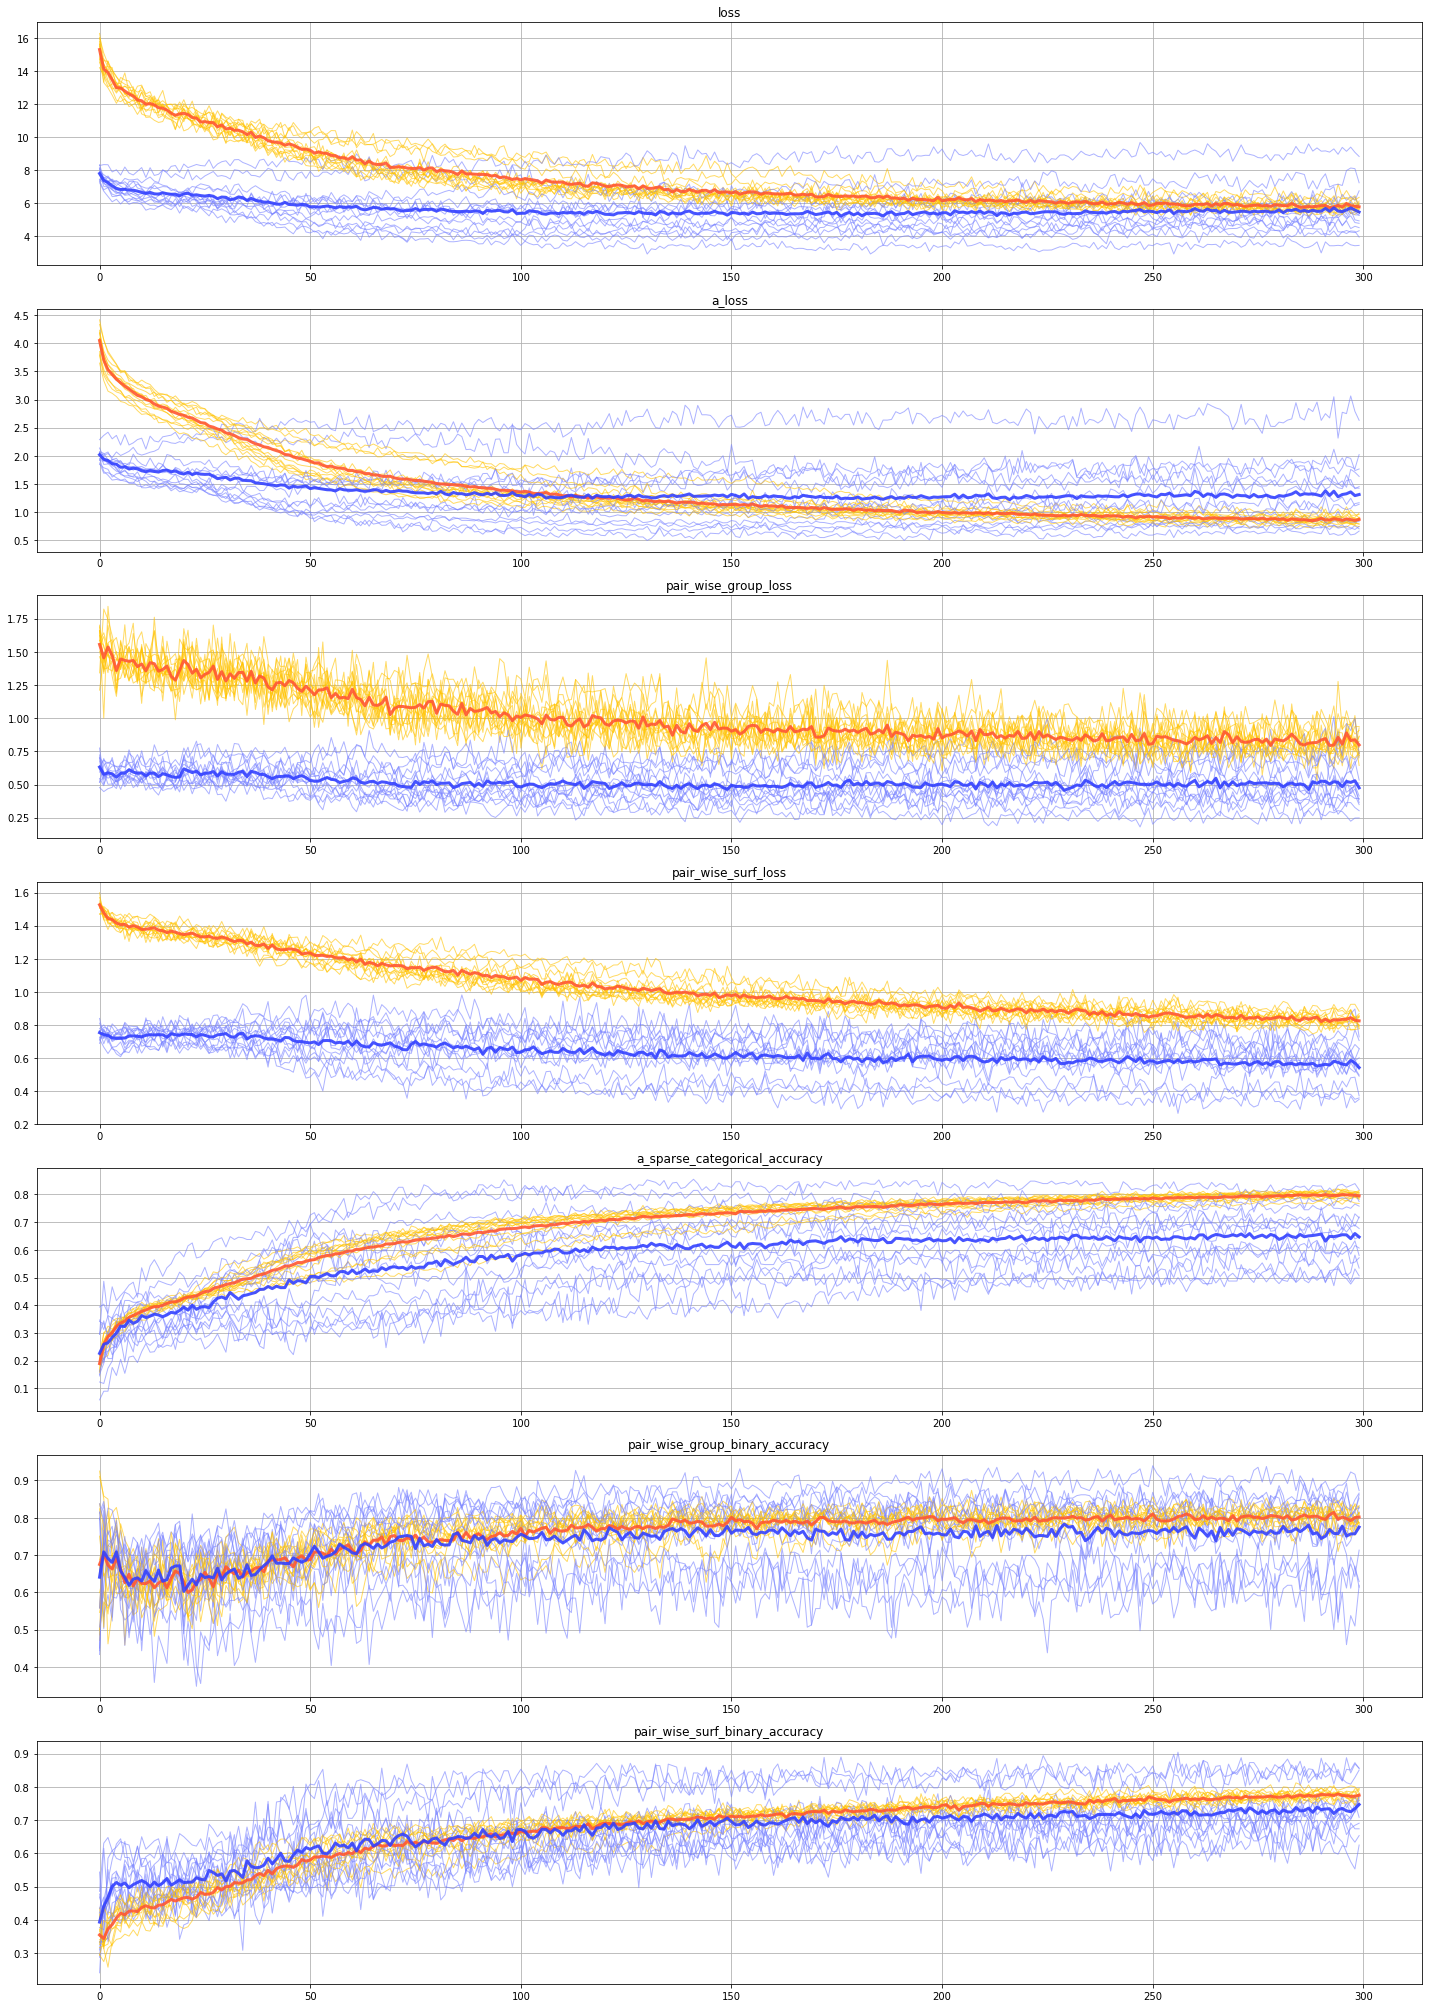

In [27]:
fig,ax=plt.subplots(len(history_keys),1,figsize=(20,4*len(history_keys)))
for ii in range(len(history_keys)):
    loss = np.zeros(shape=(hist.epoch[-1]+1))
    val_loss = np.zeros(shape=(hist.epoch[-1]+1))
    for hist in histories:
        ax[ii].plot(hist.epoch,hist.history[history_keys[ii]],'#FFC300',alpha=0.6,linewidth=1)
        ax[ii].plot(hist.epoch,hist.history["val_"+history_keys[ii]],'#7882FF',alpha=0.6,linewidth=1)
        loss += np.array(hist.history[history_keys[ii]])/len(histories)
        val_loss += np.array(hist.history["val_"+history_keys[ii]])/len(histories)
    ax[ii].plot(hist.epoch,loss,'#FF5733',alpha=0.9,linewidth=3)
    ax[ii].plot(hist.epoch,val_loss,'#3341FF',alpha=0.9,linewidth=3)
    ax[ii].grid(b=True,which='both')
    ax[ii].set_title(history_keys[ii])
    

plt.tight_layout()
plt.show()
plt.close()

In [28]:
for ii,(val,train) in enumerate(zip(validation_scores,training_scores),start=1):
    print(f'Model {ii} Validation : {np.round(val,decimals=3)}  Training : {np.round(train,decimals=3)}')
    
print(f"\n\nMean Validation Score : {np.round(np.mean(validation_scores),decimals=3)}\nMean Training Score : {np.round(np.mean(training_scores),decimals=3)}")

Model 1 Validation : 0.715  Training : 0.857
Model 2 Validation : 0.526  Training : 0.849
Model 3 Validation : 0.571  Training : 0.844
Model 4 Validation : 0.68  Training : 0.877
Model 5 Validation : 0.711  Training : 0.839
Model 6 Validation : 0.505  Training : 0.841
Model 7 Validation : 0.759  Training : 0.874
Model 8 Validation : 0.576  Training : 0.876
Model 9 Validation : 0.637  Training : 0.848
Model 10 Validation : 0.505  Training : 0.866
Model 11 Validation : 0.78  Training : 0.868
Model 12 Validation : 0.818  Training : 0.843
Model 13 Validation : 0.606  Training : 0.868


Mean Validation Score : 0.645
Mean Training Score : 0.858


,surface
concrete,706
soft_pvc,558
wood,539
soft_tiles,443
carpet,434
hard_tiles_large_space,377
tiled,350
fine_concrete,347
hard_tiles,62


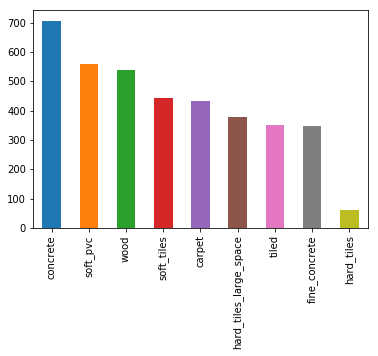

In [29]:
submission = pd.read_csv('../input/sample_submission.csv')
submission.surface = le.inverse_transform(np.array(test_scores.sum(axis=1).argmax(axis=1),dtype=np.int8))
submission.to_csv('submission.csv',index=False)
submission.surface.value_counts().plot(kind='bar')
pd.DataFrame(submission.surface.value_counts())

# Wrap-up:
Since I haven't accepted the rules, I can't do the submission to check against the test data. But I believe the results should be above 0.7.
(Would be great if someone can check that up for me)

Feel Free to subsitute your own high results model (up the 2nd last layer) in the first_inner_model generator and the last layer in second_inner_model. Let me know how much does the score improve by focusing on the reducing inter_group dependency.

*Happy Kaggling,*
AR